In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.signal import find_peaks
from scipy.stats import multivariate_normal
import csv
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from pylab import cm
from datetime import timedelta
import matplotlib.dates as mdates
from datetime import datetime

import sys
sys.path.append('../scripts')
import plotting
import importlib

plotting.set_rcParams()
#from IPython.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

#### Preparations simulations

In [ ]:
### Data loading
params = 'sp_Mmax_tau_s025_gamma01_nu100days_R5_g1_emerging'
summary = pd.read_table('../simulations/distributions/'+params+'/summarydat.dat', sep=',')
maxima = pd.read_table('../simulations/distributions/'+params+'/maximacases.dat', sep=',')

### Statistics
maxima['T'] = maxima['t']-np.roll(maxima['t'], 1)
maxima.loc[maxima['T']<0,'T'] = np.NaN
maxima['W'] = 360/maxima['T']
maxima['time_of_the_year'] = ((0+maxima['t'])%360)*52/360

#### Preparations data

In [3]:
### OWID Covid-19 data
omicron = 'beforeOmicron'
owid_peaks = pd.read_csv('../data/processed/OWID_covid19_peaks_'+omicron+'.csv', header=0, parse_dates=['date'])
owid_timeseries = pd.read_csv('../data/processed/OWID_covid19_timeseries_'+omicron+'.csv', header=0, parse_dates=['date'])
### ECDC Influenza data
ecdc_peaks = pd.read_csv('../data/processed/ECDC_influenza_peaks.csv', header=0, parse_dates=['date'])
ecdc_timeseries = pd.read_csv('../data/processed/ECDC_influenza_timeseries.csv', header=0, parse_dates=['date'])

### Simulation data
params = 'sp_Mmax_tau_s025_gamma01_nu100days_R5_g1_highRes'
summary = pd.read_table('../data/simulations/param_swipe_2D/'+params+'/summarydat.dat', sep=',')
summary = summary[summary['Mmax']>=0.75]
summary = summary.dropna()
summary = summary.reset_index()
maxima = pd.read_table('../data/simulations/param_swipe_2D/'+params+'/maximacases.dat', sep=',')
# Statistics
maxima['T'] = maxima['t']-np.roll(maxima['t'], 1)
maxima.loc[maxima['T']<0,'T'] = np.NaN
maxima['W'] = 360/maxima['T']
maxima['time_of_the_year'] = ((0+maxima['t'])%360)*52/360

## Combined figure

Mean:  3.3965809867913053
Mean:  1.0151048884365734


/tmp/ipykernel_15968/3536426070.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["","",""])
/tmp/ipykernel_15968/3536426070.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["","",""])


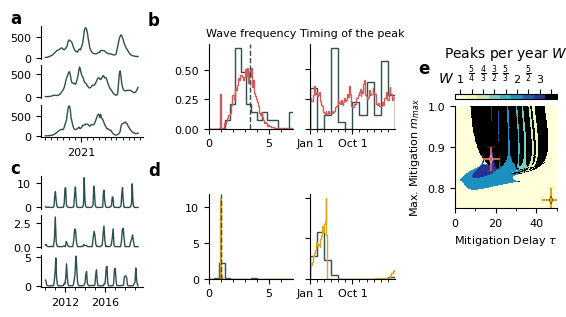

In [4]:
n = 5
m = n

fig = plt.figure(figsize=(6,3))
#I, W = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=2, ncols=1, left=.0 , right=.2 , wspace=1., hspace=.5, bottom=.05, top=.98, height_ratios=[1,1])]
"""
W               = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=1, ncols=1, left=.0 , right=.2 , wspace=1., hspace=.5, bottom=.30, top=.78, height_ratios=[1])][0]
owid_examples   = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=3, ncols=1, left=.32, right=.50, wspace=.2, hspace=.2, bottom=.55, top=.95)]
ecdc_examples   = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=3, ncols=1, left=.32, right=.50, wspace=.2, hspace=.2, bottom=.05, top=.45)]
owid_dist       = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=1, ncols=2, left=.63 , right=.95, wspace=.2, hspace=.2, bottom=.55, top=.95)]
ecdc_dist       = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=1, ncols=2, left=.63 , right=.95, wspace=.2, hspace=.2, bottom=.05, top=.45)]
"""

owid_examples   = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=3, ncols=1, left=.09, right=.26, wspace=.2, hspace=.2, bottom=.58, top=.95)]
ecdc_examples   = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=3, ncols=1, left=.09, right=.26, wspace=.2, hspace=.2, bottom=.08, top=.45)]
owid_dist       = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=1, ncols=2, left=.37 , right=.68, wspace=.2, hspace=.2, bottom=.55, top=.95)]
ecdc_dist       = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=1, ncols=2, left=.37 , right=.68, wspace=.2, hspace=.2, bottom=.05, top=.45)]
W               = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=1, ncols=1, left=.78 , right=.95 , wspace=1., hspace=.5, bottom=.30, top=.78, height_ratios=[1])][0]
example_countries_owid = ['Spain','Netherlands','France']
example_countries_ecdc = ['Spain','Netherlands','France']

simulation_owid = {'tau': 18, 'Mmax': 0.87,'color':'indianred', 'sigma_tau':4, 'sigma_Mmax':.03}
simulation_ecdc = {'tau': 47, 'Mmax': 0.77,'color':'goldenrod', 'sigma_tau':4, 'sigma_Mmax':.03}

freq_lim, time_lim = (7.01, 52)

data_color='darkslategrey'

### W
W_show, cbar = plotting.plot_arnold_imshow(W,W, summary, cbar_location='top')
W.text(-8, 1.06, r'$W$')
W.set_xticks([0,20,40], minor=False)
W.set_xticks([10,30,50], minor=True)
W.set_yticks([0.8,0.9,1], minor=False)
W.set_aspect(1.0/W.get_data_ratio(), adjustable='box')

W.errorbar(simulation_owid['tau'], simulation_owid['Mmax'], xerr=simulation_owid['sigma_tau'], yerr=simulation_owid['sigma_Mmax'], marker='d', capsize=3, color=simulation_owid['color'], markerfacecolor=simulation_owid['color'], markeredgecolor='white',markersize=4, markeredgewidth=.3)
W.errorbar(simulation_ecdc['tau'], simulation_ecdc['Mmax'], xerr=simulation_ecdc['sigma_tau'], yerr=simulation_ecdc['sigma_Mmax'], marker='d', capsize=3, color=simulation_ecdc['color'], markerfacecolor=simulation_ecdc['color'], markeredgecolor='black',markersize=4, markeredgewidth=.3)

### Example Timeseries
for country, ax, labels in zip(example_countries_owid, owid_examples, [False,False,True]):
    #ax.axes.get_yaxis().set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.axes.get_xaxis().set_visible(labels)
    ax.spines['bottom'].set_visible(labels)
    if labels:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.xaxis.set_major_locator(mdates.YearLocator())
    plotting.plot_timeseries(ax, owid_timeseries, country, color=data_color)

for country, ax, labels in zip(example_countries_ecdc, ecdc_examples, [False,False,True]):
    #ax.axes.get_yaxis().set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.axes.get_xaxis().set_visible(labels)
    ax.spines['bottom'].set_visible(labels)
    if labels:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=4))
        ax.xaxis.set_minor_locator(mdates.YearLocator())
    plotting.plot_timeseries(ax, ecdc_timeseries, country, color=data_color)

ecdc_examples[0].spines['bottom'].set_visible(False)
ecdc_examples[1].spines['bottom'].set_visible(False)

### Distributions
for ax, data, sim_params in zip([owid_dist[0], ecdc_dist[0]], [owid_peaks, ecdc_peaks],[simulation_owid, simulation_ecdc]):
    ax.hist(52/data['T'], bins=np.linspace(0,freq_lim*1.2,20), cumulative=False, histtype='step', density=True, color=data_color, lw=1.0, label='Data')
    weight={'type':'gaussian', 'sigma_tau':sim_params['sigma_tau'], 'sigma_Mmax':sim_params['sigma_Mmax']}
    sim_mean = plotting.parameter_space_histogram(ax, sim_params['tau'], sim_params['Mmax'], maxima, 'W', bins=np.linspace(0,freq_lim*1.2,100), weight=weight, cumulative=False, normalized=False, color=sim_params['color'], label='Simulation')
    ax.set_xlim(0,freq_lim)
    #ax.set_ylim(0,1)
    ax.set_xticks([1,2,3,4,6], minor=True)
    ax.set_xticks([0,5], minor=False)
    #ax.set_yticks([0,0.5,1.0])
    #ax.legend(frameon=False, loc='lower right')
    #ax.set_ylabel('Cumulative density')
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    ax.axvline((52/data['T']).mean(), color=data_color, ls='--', lw=1)
    #ax.axvline(sim_mean, color=sim_params['color'], ls='--', lw=1)
    print("Mean: ", (52/data['T']).mean())
owid_dist[0].set_title('Wave frequency')

for ax, data, sim_params in zip([owid_dist[1], ecdc_dist[1]], [owid_peaks, ecdc_peaks],[simulation_owid, simulation_ecdc]):
    ax.hist(np.minimum(data['date'].dt.isocalendar().week, 52), bins=np.linspace(0,time_lim*1.0,13), cumulative=False, histtype='step', density=True, color=data_color, lw=1.0, label='Data')
    weight={'type':'gaussian', 'sigma_tau':sim_params['sigma_tau'], 'sigma_Mmax':sim_params['sigma_Mmax']}
    plotting.parameter_space_histogram(ax, sim_params['tau'], sim_params['Mmax'], maxima, 'time_of_the_year', bins=np.linspace(0,time_lim*1.0,100), weight=weight, cumulative=False, normalized=False, color=sim_params['color'], label='Simulation')
    ax.set_xlim(0,time_lim)
    #ax.set_ylim(0,1)
    ax.set_xticks(np.arange(0,12,1)/12*52,minor=True)
    ax.set_xticks(np.arange(0,12,6)/12*52,minor=False)
    ax.set_xticklabels(['Jan 1', 'Oct 1'])
    #ax.set_yticks([0,0.5,1.0])
    ax.set_yticklabels(["","",""])
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
owid_dist[1].set_title('Timing of the peak')


### Makeup
for lab,y_delta, x_delta, ax in zip(['e','a','b','c','d'],[1.32,1.1,1.23,1.1,1.23],[-0.36,-0.3,-0.72,-0.3,-0.72], [W, owid_examples[0], owid_dist[0], ecdc_examples[0], ecdc_dist[0]]):
    ax.text(x_delta,y_delta,lab, size=12, weight='bold', color='black', transform=ax.transAxes)

### Save
plt.savefig('../figures/Fig5/Fig5_'+params+'_'+omicron+'_hist.pdf',bbox_inches='tight')
plt.show()

## Cumulative Distributions

Mean:  3.3965809867913053
Mean:  1.0151048884365734


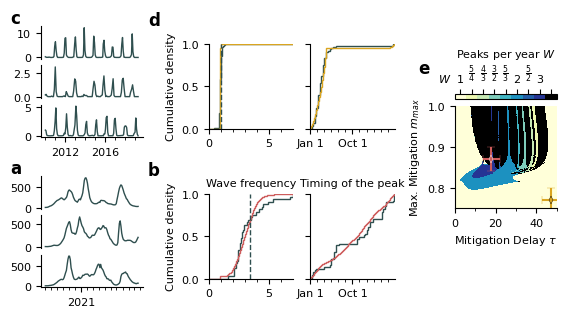

In [4]:
n = 5
m = n

fig = plt.figure(figsize=(6,3))
#I, W = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=2, ncols=1, left=.0 , right=.2 , wspace=1., hspace=.5, bottom=.05, top=.98, height_ratios=[1,1])]
"""
W               = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=1, ncols=1, left=.0 , right=.2 , wspace=1., hspace=.5, bottom=.30, top=.78, height_ratios=[1])][0]
owid_examples   = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=3, ncols=1, left=.32, right=.50, wspace=.2, hspace=.2, bottom=.55, top=.95)]
ecdc_examples   = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=3, ncols=1, left=.32, right=.50, wspace=.2, hspace=.2, bottom=.05, top=.45)]
owid_dist       = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=1, ncols=2, left=.63 , right=.95, wspace=.2, hspace=.2, bottom=.55, top=.95)]
ecdc_dist       = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=1, ncols=2, left=.63 , right=.95, wspace=.2, hspace=.2, bottom=.05, top=.45)]
"""

ecdc_examples   = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=3, ncols=1, left=.09, right=.26, wspace=.2, hspace=.2, bottom=.58, top=.95)]
owid_examples   = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=3, ncols=1, left=.09, right=.26, wspace=.2, hspace=.2, bottom=.08, top=.45)]
ecdc_dist       = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=1, ncols=2, left=.37 , right=.68, wspace=.2, hspace=.2, bottom=.55, top=.95)]
owid_dist       = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=1, ncols=2, left=.37 , right=.68, wspace=.2, hspace=.2, bottom=.05, top=.45)]
W               = [fig.add_subplot(x) for x in gridspec.GridSpec(nrows=1, ncols=1, left=.78 , right=.95 , wspace=1., hspace=.5, bottom=.30, top=.78, height_ratios=[1])][0]
example_countries_owid = ['Spain','Netherlands','France']
example_countries_ecdc = ['Spain','Netherlands','France']

simulation_owid = {'tau': 18, 'Mmax': 0.87,'color':'indianred', 'sigma_tau':4, 'sigma_Mmax':.03}
simulation_ecdc = {'tau': 47, 'Mmax': 0.77,'color':'goldenrod', 'sigma_tau':4, 'sigma_Mmax':.03}

freq_lim, time_lim = (7.01, 52)

data_color='darkslategrey'

### W
W_show, cbar = plotting.plot_arnold_imshow(W,W, summary, cbar_location='top')
W.text(-8, 1.06, r'$W$')
W.set_xticks([0,20,40], minor=False)
W.set_xticks([10,30,50], minor=True)
W.set_yticks([0.8,0.9,1], minor=False)
W.set_aspect(1.0/W.get_data_ratio(), adjustable='box')

W.errorbar(simulation_owid['tau'], simulation_owid['Mmax'], xerr=simulation_owid['sigma_tau'], yerr=simulation_owid['sigma_Mmax'], marker='d', capsize=3, color=simulation_owid['color'], markerfacecolor=simulation_owid['color'], markeredgecolor='white',markersize=4, markeredgewidth=.3)
W.errorbar(simulation_ecdc['tau'], simulation_ecdc['Mmax'], xerr=simulation_ecdc['sigma_tau'], yerr=simulation_ecdc['sigma_Mmax'], marker='d', capsize=3, color=simulation_ecdc['color'], markerfacecolor=simulation_ecdc['color'], markeredgecolor='black',markersize=4, markeredgewidth=.3)

### Example Timeseries
for country, ax, labels in zip(example_countries_owid, owid_examples, [False,False,True]):
    #ax.axes.get_yaxis().set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.axes.get_xaxis().set_visible(labels)
    ax.spines['bottom'].set_visible(labels)
    if labels:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.xaxis.set_major_locator(mdates.YearLocator())
    plotting.plot_timeseries(ax, owid_timeseries, country, color=data_color)

for country, ax, labels in zip(example_countries_ecdc, ecdc_examples, [False,False,True]):
    #ax.axes.get_yaxis().set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.axes.get_xaxis().set_visible(labels)
    ax.spines['bottom'].set_visible(labels)
    if labels:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=4))
        ax.xaxis.set_minor_locator(mdates.YearLocator())
    plotting.plot_timeseries(ax, ecdc_timeseries, country, color=data_color)

ecdc_examples[0].spines['bottom'].set_visible(False)
ecdc_examples[1].spines['bottom'].set_visible(False)

### Distributions
for ax, data, sim_params in zip([owid_dist[0], ecdc_dist[0]], [owid_peaks, ecdc_peaks],[simulation_owid, simulation_ecdc]):
    ax.hist(52/data['T'], bins=np.linspace(0,freq_lim*1.2,200), cumulative=True, histtype='step', density=True, color=data_color, lw=1.0, label='Data')
    weight={'type':'gaussian', 'sigma_tau':sim_params['sigma_tau'], 'sigma_Mmax':sim_params['sigma_Mmax']}
    sim_mean = plotting.parameter_space_histogram(ax, sim_params['tau'], sim_params['Mmax'], maxima, 'W', bins=np.linspace(0,freq_lim*1.2,200), weight=weight, cumulative=True, normalized=False, color=sim_params['color'], label='Simulation')
    ax.set_xlim(0,freq_lim)
    ax.set_ylim(0,1)
    ax.set_xticks([1,2,3,4,6], minor=True)
    ax.set_xticks([0,5], minor=False)
    ax.set_yticks([0,0.5,1.0])
    #ax.legend(frameon=False, loc='lower right')
    ax.set_ylabel('Cumulative density')
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    ax.axvline((52/data['T']).mean(), color=data_color, ls='--', lw=1)
    #ax.axvline(sim_mean, color=sim_params['color'], ls='--', lw=1)
    print("Mean: ", (52/data['T']).mean())
owid_dist[0].set_title('Wave frequency')

for ax, data, sim_params in zip([owid_dist[1], ecdc_dist[1]], [owid_peaks, ecdc_peaks],[simulation_owid, simulation_ecdc]):
    ax.hist(np.minimum(data['date'].dt.isocalendar().week, 52), bins=np.linspace(0,time_lim*1.2,200), cumulative=True, histtype='step', density=True, color=data_color, lw=1.0, label='Data')
    weight={'type':'gaussian', 'sigma_tau':sim_params['sigma_tau'], 'sigma_Mmax':sim_params['sigma_Mmax']}
    plotting.parameter_space_histogram(ax, sim_params['tau'], sim_params['Mmax'], maxima, 'time_of_the_year', bins=np.linspace(0,time_lim*1.2,200), weight=weight, cumulative=True, normalized=False, color=sim_params['color'], label='Simulation')
    ax.set_xlim(0,time_lim)
    ax.set_ylim(0,1)
    ax.set_xticks(np.arange(0,12,1)/12*52,minor=True)
    ax.set_xticks(np.arange(0,12,6)/12*52,minor=False)
    ax.set_xticklabels(['Jan 1', 'Oct 1'])
    ax.set_yticks([0,0.5,1.0])
    ax.set_yticklabels(["","",""])
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
owid_dist[1].set_title('Timing of the peak')


### Makeup
for lab,y_delta, x_delta, ax in zip(['e','a','b','c','d'],[1.32,1.1,1.23,1.1,1.23],[-0.36,-0.3,-0.72,-0.3,-0.72], [W, owid_examples[0], owid_dist[0], ecdc_examples[0], ecdc_dist[0]]):
    ax.text(x_delta,y_delta,lab, size=12, weight='bold', color='black', transform=ax.transAxes)

### Save
plt.savefig('../figures/Fig5/Fig5_'+params+'_'+omicron+'_new.pdf')
plt.show()